Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ThermoDoc documents:   0%|          | 0/218 [00:00<?, ?it/s]

[0.006397966666667069]


<Axes: xlabel='pH', ylabel='E (V)'>

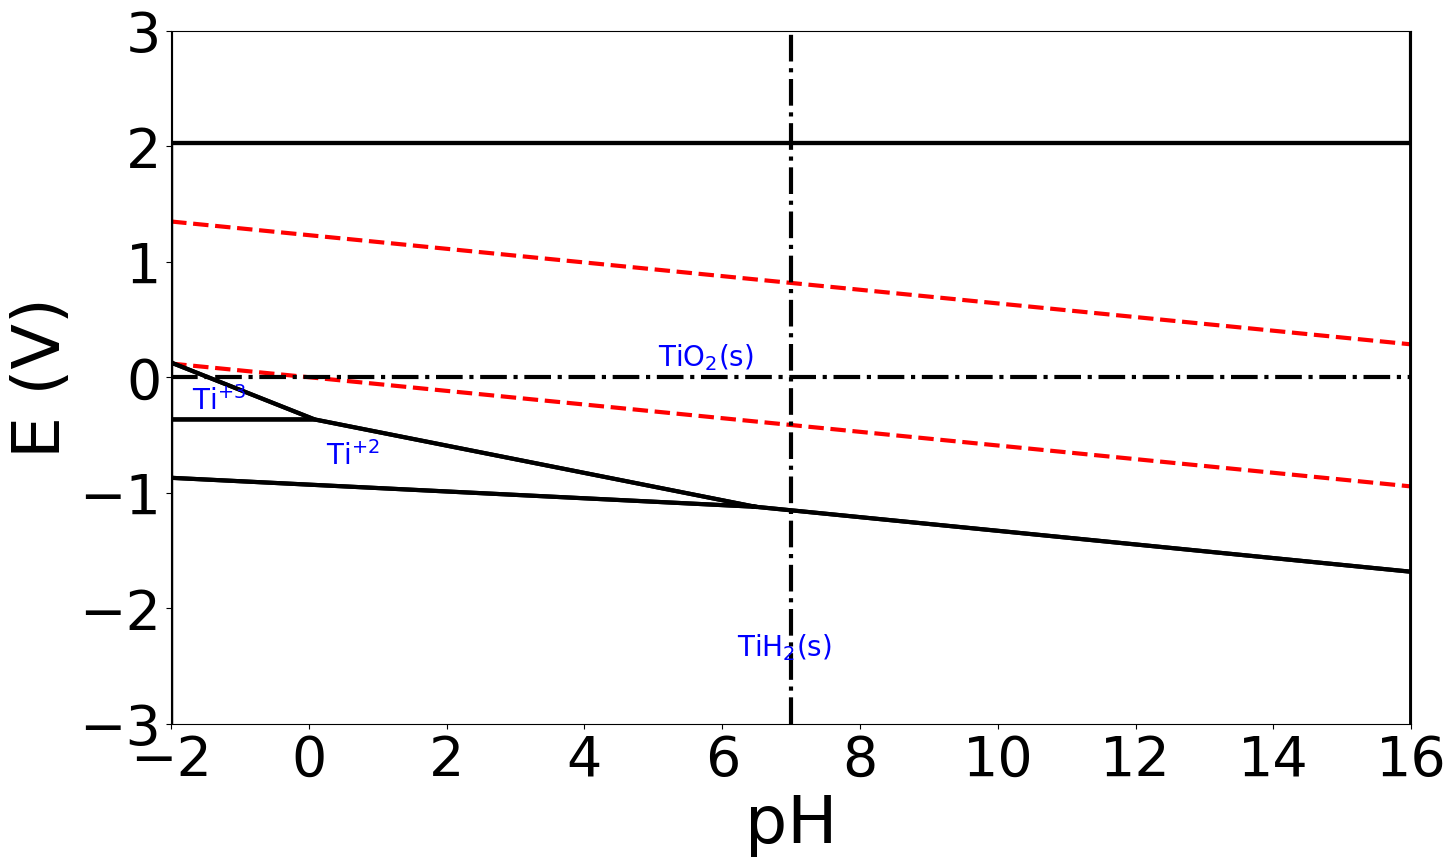

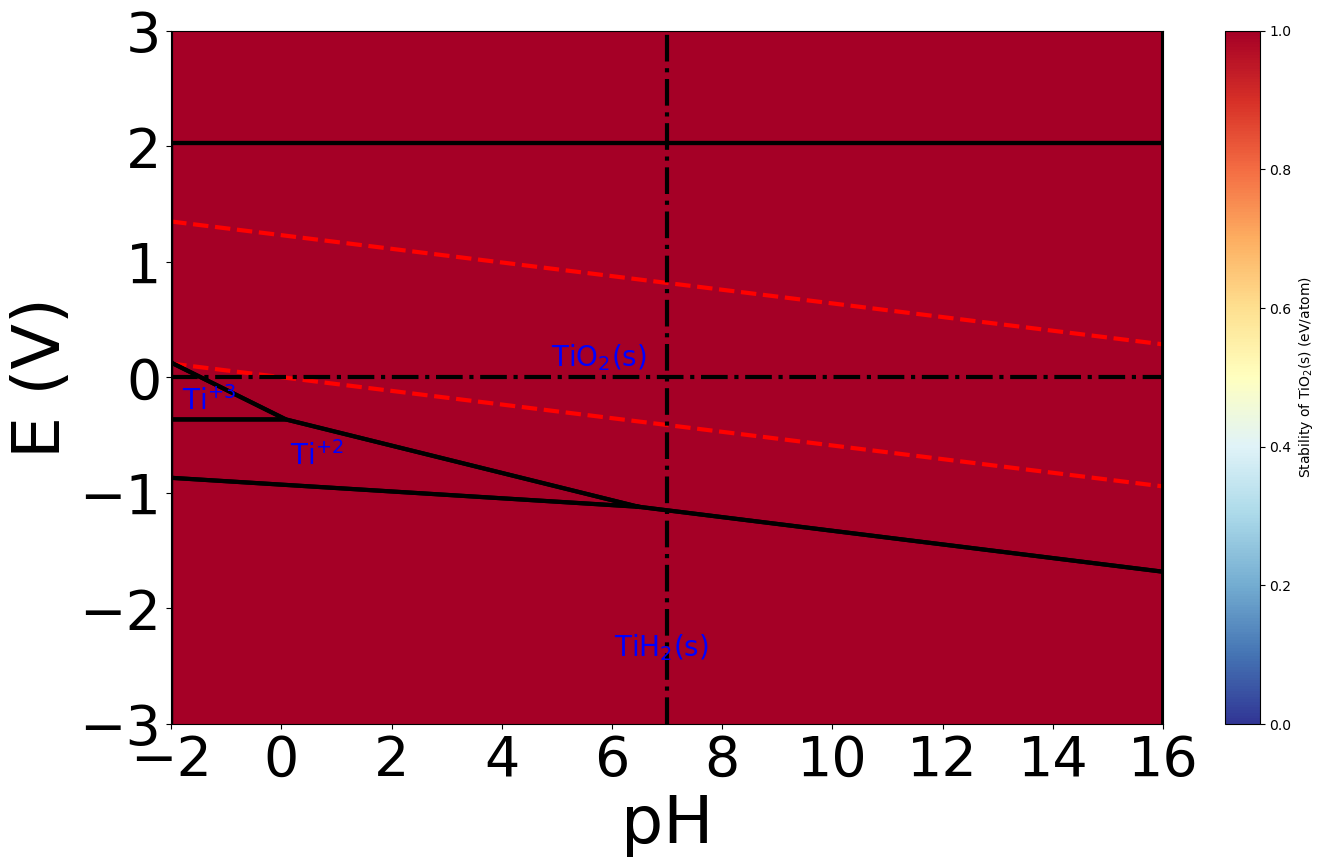

In [16]:
from mp_api.client import MPRester
from pymatgen.analysis.pourbaix_diagram import PourbaixDiagram, PourbaixPlotter, PourbaixEntry

from api_key import APIKEY

API_KEY = APIKEY

materials = ['mp-390']
shorten_materials = materials[:2]

mp_entries = []

with MPRester(API_KEY) as mpr:
    for mp_id in shorten_materials:
        material_entries = mpr.materials.search(material_ids=[mp_id])

        if material_entries:
            mp_entries.append(material_entries[0])

chemsys_list = [entry.chemsys for entry in mp_entries if hasattr(entry, 'chemsys')]
composition_list = [entry.composition_reduced for entry in mp_entries if hasattr(entry, 'composition_reduced')]
materials_gga = [material + "-GGA" for material in shorten_materials]
materials_id = shorten_materials

from pymatgen.core.composition import Composition

def remove_o_and_h(composition):
    new_composition_elements = []
    for element, count in composition.get_el_amt_dict().items():
        if element not in ['O', 'H']:
            new_composition_elements.append(f"{element}{int(count)}")
    new_composition_str = ' '.join(new_composition_elements)
    return Composition(new_composition_str)

filtered_molecules = [remove_o_and_h(molecule) for molecule in composition_list]

from pymatgen.core.composition import Composition

def calculate_percent_composition(molecule):
    total_atoms = sum(molecule.values())
    return {element.symbol: count / total_atoms for element, count in molecule.items()}

percent_compositions = [calculate_percent_composition(molecule) for molecule in filtered_molecules]

pbx_data = []
pbx_entries = []

total_iterations = len(chemsys_list)  

with MPRester(API_KEY) as mpr:
    for index, (i, x) in enumerate(zip(chemsys_list, percent_compositions)):
        try:
            pourbaix_entries = mpr.get_pourbaix_entries(i)
            pbx_entries.append(pourbaix_entries)
            pbx_diagram = PourbaixDiagram(entries=pourbaix_entries, comp_dict=x)
            pbx_data.append(pbx_diagram)
        except Exception as e:
            pbx_data.append('error')
        
        percent_complete = ((index + 1) / total_iterations) * 100

matched_entries = []

for mat_id, entries in zip(materials_gga, pbx_entries):
    matched_entry = next((entry for entry in entries if entry.entry_id == mat_id), None)
    
    if matched_entry:
        matched_entries.append(matched_entry)
    else:
        matched_entries.append(None)

stabilities = []

for i, x in zip(pbx_data, matched_entries):
    try:
        stability = i.get_decomposition_energy(x, 7, 0)
        stabilities.append(stability)
    except Exception as e:
        stabilities.append("error") 

print(stabilities)

combined_list = list(zip(materials_id, stabilities))
data_without_error = [item for item in combined_list if item[1] != 'error']
filtered_data = [item for item in data_without_error if float(item[1]) <= 0.5]
mp_identifiers = [item[0] for item in filtered_data]

plotter = PourbaixPlotter(pbx_data[0])
plotter.get_pourbaix_plot()
pbe = PourbaixEntry(matched_entries[0])
plotter.plot_entry_stability(pbe)